In [27]:
# Manual time-based cross-validation for ternary model
from pathlib import Path
import os
import pandas as pd
from IPython.display import display, Markdown

# Paths
ROOT = Path.cwd().parent  # notebooks -> upreg_classify
DATA_PATH = ROOT / 'reports' / 'dataframes' / 'multiclass_dataset.csv'
MODELS_ROOT = ROOT / 'models'

# Candidate model dirs (reusing your existing pattern)
CANDIDATES = [
    MODELS_ROOT / 'quick_exclude_persistency_check',
    MODELS_ROOT / 'quick_eval_print_check2',
    MODELS_ROOT / 'quick_persistency_check',
]

MODELS = next((p for p in CANDIDATES if p.exists()), CANDIDATES[-1])
FIGS = ROOT / 'reports' / 'figures' / 'manual_time_cv'

print(f"ROOT:   {ROOT}")
print(f"DATA:   {DATA_PATH}")
print(f"MODELS: {MODELS}")
print(f"FIGS:   {FIGS}")

assert DATA_PATH.exists(), f"Missing dataset: {DATA_PATH}"
FIGS.mkdir(parents=True, exist_ok=True)

ROOT:   c:\PythonProjects\rl_reserve_markets\upreg_classify
DATA:   c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\dataframes\multiclass_dataset.csv
MODELS: c:\PythonProjects\rl_reserve_markets\upreg_classify\models\quick_exclude_persistency_check
FIGS:   c:\PythonProjects\rl_reserve_markets\upreg_classify\reports\figures\manual_time_cv


In [28]:
# Load dataset from preprocessing pipeline (no cached CSV)
import os
import sys
import pandas as pd
from datetime import datetime

# Ensure repo root on sys.path to import src modules
THIS_NOTEBOOK_DIR = os.getcwd()
REPO_ROOT = os.path.abspath(os.path.join(THIS_NOTEBOOK_DIR, '..'))
if REPO_ROOT not in sys.path:
    sys.path.append(REPO_ROOT)

from src.data.preprocess import Config, build_dataset

cfg = Config(
    data_dir=os.path.join('..','data', 'raw'),
    area='NO1',
    include_2024=True,
    drop_future=True,
    heavy_interactions=False,
    dropna=True,
    train_frac=0.6,
    val_frac=0.2,
    test_frac=0.2,
)

label_col = 'RegClass+4'

# Build full dataset, then restrict to dates >= 4 March 2025
df_full, (train_df_orig, val_df_orig, test_df_orig), features = build_dataset(cfg, label_name=label_col)
print(f"Built dataset via preprocess.build_dataset: total={len(df_full)}, train={len(train_df_orig)}, val={len(val_df_orig)}, test={len(test_df_orig)}")

# Persist full dataset snapshot for reuse in other analyses
SNAP_PATH = os.path.join('reports', 'dataframes', 'multiclass_full_dataset.csv')
os.makedirs(os.path.dirname(SNAP_PATH), exist_ok=True)
df_full.to_csv(SNAP_PATH)
print("Saved full dataset snapshot to:", SNAP_PATH)

# Restrict to data starting at 2025-03-04 00:00
cutoff = datetime(2025, 3, 4)
df = df_full[df_full.index >= cutoff].copy()
print(f"After cutoff {cutoff:%Y-%m-%d}, rows={len(df)}")

# Recompute contiguous train/val/test splits on the truncated df
n_total = len(df)
n_train = int(n_total * cfg.train_frac)
n_val = int(n_total * cfg.val_frac)
train_df_orig = df.iloc[:n_train]
val_df_orig = df.iloc[n_train:n_train + n_val]
test_df_orig = df.iloc[n_train + n_val:]
print(f"Truncated splits -> train={len(train_df_orig)}, val={len(val_df_orig)}, test={len(test_df_orig)}")

# For manual time-based CV, recombine train+val and keep test as-is
trainval_df = pd.concat([train_df_orig, val_df_orig], axis=0).sort_index()
test_df = test_df_orig.copy()
print(len(trainval_df), "train+val rows,", len(test_df), "test rows")

Flow index range: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
aFRR activation data rows before processing: 70176
aFRR price data rows before processing: 66045
Final index range pre-dropna: 2024-01-01 00:00:00 -> 2025-12-04 23:45:00 (rows=67584)
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 13)
aFRR data shape: (66045, 6)
flows shape: (67584, 8)
Number of NaNs before dropna: 10769
Final preprocessed DataFrame shape: (65720, 66)
Dataset splits: train=39432, val=13144, test=13144 (total=65720)
Built dataset via preprocess.build_dataset: total=65720, train=39432, val=13144, test=13144
Consumption shape: (67584, 1)
Production shape: (67449, 8)
Day-ahead prices shape: (67776, 2)
Intraday hourly stats shape: (67581, 1

In [29]:
# Build forward-chaining time-based CV folds on train+val
import math

n_folds = 5
n = len(trainval_df)

# Compute contiguous block sizes by position
fold_sizes = [n // n_folds] * n_folds
for i in range(n % n_folds):
    fold_sizes[i] += 1

folds = []
val_start = 0
for k, size in enumerate(fold_sizes):
    val_end = val_start + size
    # Validation is the next time block (future relative to training)
    val_fold = trainval_df.iloc[val_start:val_end]
    # Training is everything strictly before that block
    train_fold = trainval_df.iloc[:val_start]
    folds.append((train_fold, val_fold))
    print(f"Fold {k}: train={len(train_fold)}, val={len(val_fold)}")
    val_start = val_end

# Sanity check: ensure folds cover the whole trainval range without overlap gaps
total_val = sum(len(v) for _, v in folds)
print("Total val rows across folds:", total_val, "(expected", n, ")")

Fold 0: train=0, val=4218
Fold 1: train=4218, val=4218
Fold 2: train=8436, val=4218
Fold 3: train=12654, val=4217
Fold 4: train=16871, val=4217
Total val rows across folds: 21088 (expected 21088 )


In [30]:
def add_class_weights(df, label_col="RegClass+4"):
    # adjust ratios after you look at class balance
    weights = {
        "up":   5.0,   # rare class: heavier
        "down": 1.0,
        "none": 1.0,
    }
    df = df.copy()
    df["sample_weight"] = df[label_col].map(weights)
    return df


In [34]:
# Train one Autogluon model per fold and collect metrics (CatBoost only, chronological tuning_data)
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

results = []

# Optional: subfolder name for this CV run
cv_run_name = "manual_timecv_2024_2025_cat_only"

hyperparams = {
    "CAT": {}
}

for k, (train_fold, val_fold) in enumerate(folds):
    print(f"\n=== Fold {k} ===")
    if len(train_fold) == 0:
        print("Skipping fold because train_fold is empty (forward-chaining warm-up).")
        continue
    if len(val_fold) == 0:
        print("Skipping fold because val_fold is empty.")
        continue

    fold_dir = MODELS_ROOT / cv_run_name / f"fold{k}"
    fold_dir.mkdir(parents=True, exist_ok=True)
    
    train_fold = add_class_weights(train_fold, label_col=label_col)

    predictor = TabularPredictor(
        label=label_col,
        path=str(fold_dir),
        problem_type="multiclass",
        sample_weight="sample_weight",
        eval_metric="f1_macro",
).fit(
        train_data=train_fold,
        tuning_data=val_fold,  # chronological validation
        presets="medium_quality_faster_train",
        
        hyperparameters=hyperparams,
        num_bag_folds=0,
        time_limit=None,
)

    y_true = val_fold[label_col].astype(str)
    y_pred = predictor.predict(val_fold)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    print(f"Fold {k} f1_macro={f1m:.4f}, acc={acc:.4f}")

    results.append({"fold": k, "f1_macro": f1m, "accuracy": acc, "n_val": len(val_fold)})

cv_results = pd.DataFrame(results)
display(Markdown("## Manual time-based CV results (CatBoost only, chrono tuning_data)"))
display(cv_results)
print("Mean f1_macro:", cv_results["f1_macro"].mean())
print("Mean accuracy:", cv_results["accuracy"].mean())

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.08 GB / 13.85 GB (22.2%)
Disk Space Avail:   391.95 GB / 952.62 GB (41.1%)
Presets specified: ['medium_quality_faster_train']
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.08 GB / 13.85 GB (22.2%)
Disk Space Avail:   391.95 GB / 952.62 GB (41.1%)
Presets specified: ['medium_quality_faster_train']
Cannot interpret 'Int8Dtype()' as a data type
Cannot


=== Fold 0 ===
Skipping fold because train_fold is empty (forward-chaining warm-up).

=== Fold 1 ===


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold1"
Train Data Rows:    4218
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold1"
Train Data Rows:    4218
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fi

Fold 1 f1_macro=0.4541, acc=0.6003

=== Fold 2 ===


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold2"
Train Data Rows:    8436
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold2"
Train Data Rows:    8436
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatur

Fold 2 f1_macro=0.5578, acc=0.6581

=== Fold 3 ===


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold3"
Train Data Rows:    12654
Train Data Columns: 66
Tuning Data Rows:    4217
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold3"
Train Data Rows:    12654
Train Data Columns: 66
Tuning Data Rows:    4217
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeat

Fold 3 f1_macro=0.5342, acc=0.6360

=== Fold 4 ===


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold4"
Train Data Rows:    16871
Train Data Columns: 66
Tuning Data Rows:    4217
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\fold4"
Train Data Rows:    16871
Train Data Columns: 66
Tuning Data Rows:    4217
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Train Data Class Count: 3


Fold 4 f1_macro=0.5409, acc=0.5689


## Manual time-based CV results (CatBoost only, chrono tuning_data)

,fold,f1_macro,accuracy,n_val
0,1,0.454101,0.600284,4218
1,2,0.557819,0.658132,4218
2,3,0.534212,0.635997,4217
3,4,0.540870,0.568888,4217


Mean f1_macro: 0.5217502269142035
Mean accuracy: 0.6158253250941993


Class order: ['down', 'none', 'up']

=== Fold 1 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.74      0.66      0.70      2317
        none       0.47      0.67      0.55      1445
          up       0.39      0.07      0.11       456

    accuracy                           0.60      4218
   macro avg       0.53      0.47      0.45      4218
weighted avg       0.61      0.60      0.59      4218

Classification report (validation):
              precision    recall  f1-score   support

        down       0.74      0.66      0.70      2317
        none       0.47      0.67      0.55      1445
          up       0.39      0.07      0.11       456

    accuracy                           0.60      4218
   macro avg       0.53      0.47      0.45      4218
weighted avg       0.61      0.60      0.59      4218



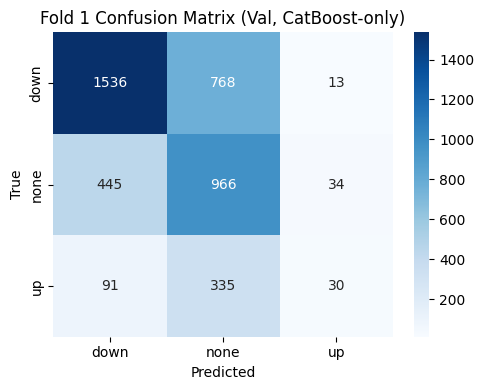


=== Fold 2 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.68      0.86      0.76      2190
        none       0.68      0.44      0.54      1739
          up       0.35      0.40      0.37       289

    accuracy                           0.66      4218
   macro avg       0.57      0.57      0.56      4218
weighted avg       0.66      0.66      0.64      4218

Classification report (validation):
              precision    recall  f1-score   support

        down       0.68      0.86      0.76      2190
        none       0.68      0.44      0.54      1739
          up       0.35      0.40      0.37       289

    accuracy                           0.66      4218
   macro avg       0.57      0.57      0.56      4218
weighted avg       0.66      0.66      0.64      4218



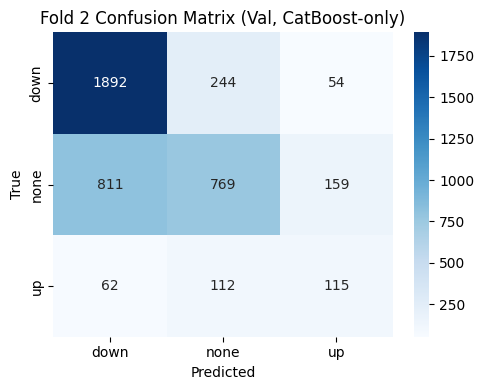


=== Fold 3 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.66      0.77      0.71      1996
        none       0.65      0.61      0.63      1720
          up       0.36      0.21      0.26       501

    accuracy                           0.64      4217
   macro avg       0.56      0.53      0.53      4217
weighted avg       0.62      0.64      0.62      4217

Classification report (validation):
              precision    recall  f1-score   support

        down       0.66      0.77      0.71      1996
        none       0.65      0.61      0.63      1720
          up       0.36      0.21      0.26       501

    accuracy                           0.64      4217
   macro avg       0.56      0.53      0.53      4217
weighted avg       0.62      0.64      0.62      4217



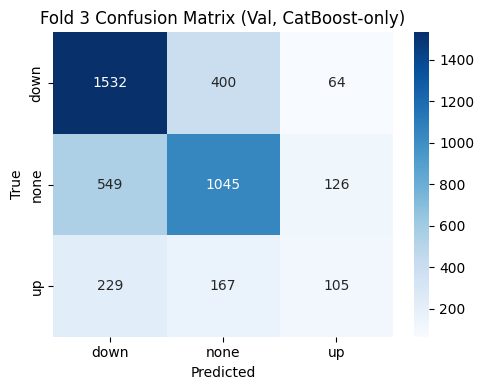


=== Fold 4 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.54      0.62      0.58      1285
        none       0.75      0.54      0.63      2315
          up       0.33      0.57      0.42       617

    accuracy                           0.57      4217
   macro avg       0.54      0.58      0.54      4217
weighted avg       0.62      0.57      0.58      4217

Classification report (validation):
              precision    recall  f1-score   support

        down       0.54      0.62      0.58      1285
        none       0.75      0.54      0.63      2315
          up       0.33      0.57      0.42       617

    accuracy                           0.57      4217
   macro avg       0.54      0.58      0.54      4217
weighted avg       0.62      0.57      0.58      4217



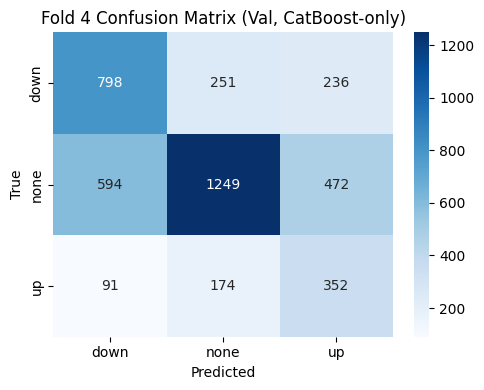

In [35]:
# Detailed diagnostics: classification reports and confusion matrices for folds and test set (CatBoost-only run)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels_sorted = sorted(trainval_df[label_col].astype(str).unique().tolist())
print("Class order:", labels_sorted)

# Per-fold reports using already-fitted predictors on disk
fold_reports = []
for row in cv_results.itertuples(index=False):
    fold_k = int(row.fold)
    print(f"\n=== Fold {fold_k} diagnostics (CatBoost-only) ===")
    fold_dir = MODELS_ROOT / "manual_timecv_2024_2025_cat_only" / f"fold{fold_k}"
    predictor_fold = TabularPredictor.load(str(fold_dir))
    _, val_fold = folds[fold_k]
    y_true_val = val_fold[label_col].astype(str)
    y_pred_val = predictor_fold.predict(val_fold)

    print("Classification report (validation):")
    print(classification_report(y_true_val, y_pred_val, labels=labels_sorted, zero_division=0))

    cm = confusion_matrix(y_true_val, y_pred_val, labels=labels_sorted)
    cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)
    fold_reports.append({"fold": fold_k, "report": cm_df})

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold_k} Confusion Matrix (Val, CatBoost-only)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [38]:
# Train final model on full train+val and evaluate on test set (CatBoost only, same config)
from autogluon.tabular import TabularPredictor
from sklearn.metrics import f1_score, accuracy_score

final_root = MODELS_ROOT / "manual_timecv_2024_2025_cat_only"
final_dir = final_root / "final_full_trainval"
final_dir.mkdir(parents=True, exist_ok=True)

# train = 0.8 of previous train, val is rest
actual_train_size = int(0.8 * len(trainval_df))
train_final = trainval_df.iloc[:actual_train_size]
val_final = trainval_df.iloc[actual_train_size:]
train_final = add_class_weights(train_final, label_col=label_col)

print("\n=== Final model on full train+val, evaluated on test (2024-2025 CatBoost-only run) ===")
final_predictor = TabularPredictor(
    label=label_col,
    path=str(final_dir),
    problem_type="multiclass",
    eval_metric="f1_macro",
    sample_weight="sample_weight"
).fit(
    train_data=train_final,
    tuning_data=val_final,
    presets="medium_quality_faster_train",
    hyperparameters={"CAT": {
        
        }},
    num_bag_folds=0,
    time_limit=None,
)

y_true_test = test_df[label_col].astype(str)
y_pred_test = final_predictor.predict(test_df)
f1m_test = f1_score(y_true_test, y_pred_test, average="macro", zero_division=0)
acc_test = accuracy_score(y_true_test, y_pred_test)
print(f"Test f1_macro={f1m_test:.4f}, acc={acc_test:.4f}, n_test={len(test_df)}")

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.08 GB / 13.85 GB (22.3%)
Disk Space Avail:   391.88 GB / 952.62 GB (41.1%)
Presets specified: ['medium_quality_faster_train']
Cannot interpret 'Int8Dtype()' as a data type
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.08 GB / 13.85 GB (22.3%)
Disk Space Avail:   391.88 GB / 952.62 GB (41.1%)
Presets specified: ['medium_quality_faster_train']
Cannot


=== Final model on full train+val, evaluated on test (2024-2025 CatBoost-only run) ===


Values in column 'sample_weight' used as sample weights instead of predictive features. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\final_full_trainval"
Train Data Rows:    16870
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Beginning AutoGluon training ...
AutoGluon will save models to "c:\PythonProjects\rl_reserve_markets\upreg_classify\models\manual_timecv_2024_2025_cat_only\final_full_trainval"
Train Data Rows:    16870
Train Data Columns: 66
Tuning Data Rows:    4218
Tuning Data Columns: 65
Label Column:       RegClass+4
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ..

Test f1_macro=0.5257, acc=0.5708, n_test=5272


Class order: ['down', 'none', 'up']

=== Fold 1 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.74      0.66      0.70      2317
        none       0.47      0.67      0.55      1445
          up       0.39      0.07      0.11       456

    accuracy                           0.60      4218
   macro avg       0.53      0.47      0.45      4218
weighted avg       0.61      0.60      0.59      4218

Classification report (validation):
              precision    recall  f1-score   support

        down       0.74      0.66      0.70      2317
        none       0.47      0.67      0.55      1445
          up       0.39      0.07      0.11       456

    accuracy                           0.60      4218
   macro avg       0.53      0.47      0.45      4218
weighted avg       0.61      0.60      0.59      4218



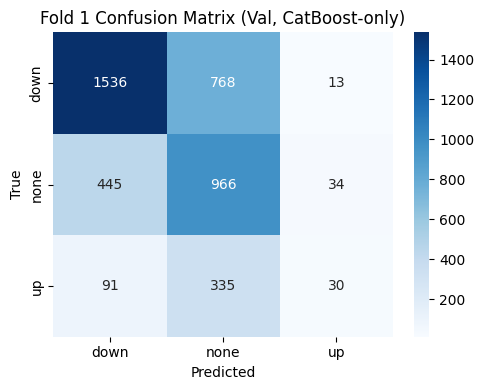


=== Fold 2 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.68      0.86      0.76      2190
        none       0.68      0.44      0.54      1739
          up       0.35      0.40      0.37       289

    accuracy                           0.66      4218
   macro avg       0.57      0.57      0.56      4218
weighted avg       0.66      0.66      0.64      4218

Classification report (validation):
              precision    recall  f1-score   support

        down       0.68      0.86      0.76      2190
        none       0.68      0.44      0.54      1739
          up       0.35      0.40      0.37       289

    accuracy                           0.66      4218
   macro avg       0.57      0.57      0.56      4218
weighted avg       0.66      0.66      0.64      4218



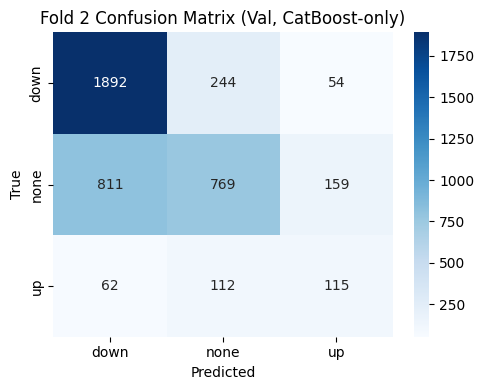


=== Fold 3 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.66      0.77      0.71      1996
        none       0.65      0.61      0.63      1720
          up       0.36      0.21      0.26       501

    accuracy                           0.64      4217
   macro avg       0.56      0.53      0.53      4217
weighted avg       0.62      0.64      0.62      4217

Classification report (validation):
              precision    recall  f1-score   support

        down       0.66      0.77      0.71      1996
        none       0.65      0.61      0.63      1720
          up       0.36      0.21      0.26       501

    accuracy                           0.64      4217
   macro avg       0.56      0.53      0.53      4217
weighted avg       0.62      0.64      0.62      4217



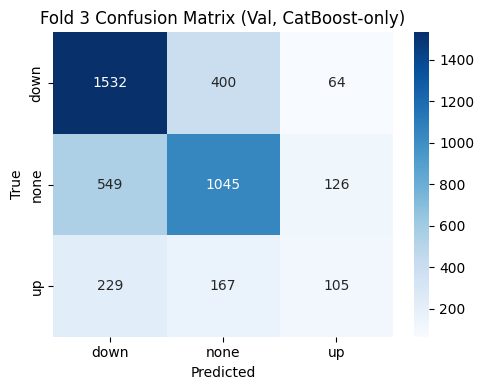


=== Fold 4 diagnostics (CatBoost-only) ===
Classification report (validation):
              precision    recall  f1-score   support

        down       0.54      0.62      0.58      1285
        none       0.75      0.54      0.63      2315
          up       0.33      0.57      0.42       617

    accuracy                           0.57      4217
   macro avg       0.54      0.58      0.54      4217
weighted avg       0.62      0.57      0.58      4217

Classification report (validation):
              precision    recall  f1-score   support

        down       0.54      0.62      0.58      1285
        none       0.75      0.54      0.63      2315
          up       0.33      0.57      0.42       617

    accuracy                           0.57      4217
   macro avg       0.54      0.58      0.54      4217
weighted avg       0.62      0.57      0.58      4217



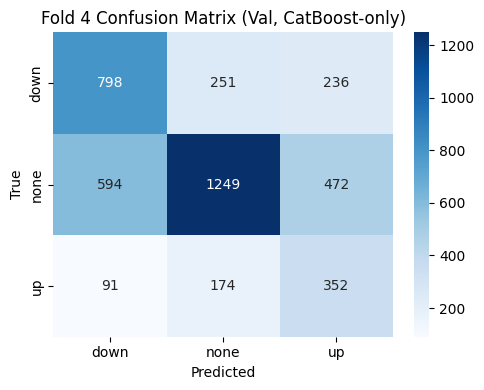


=== Test set diagnostics (final model, 2024-2025 CatBoost-only run) ===
Classification report (test):
              precision    recall  f1-score   support

        down       0.59      0.67      0.62      1961
        none       0.63      0.56      0.59      2519
          up       0.36      0.36      0.36       792

    accuracy                           0.57      5272
   macro avg       0.52      0.53      0.53      5272
weighted avg       0.57      0.57      0.57      5272

Classification report (test):
              precision    recall  f1-score   support

        down       0.59      0.67      0.62      1961
        none       0.63      0.56      0.59      2519
          up       0.36      0.36      0.36       792

    accuracy                           0.57      5272
   macro avg       0.52      0.53      0.53      5272
weighted avg       0.57      0.57      0.57      5272



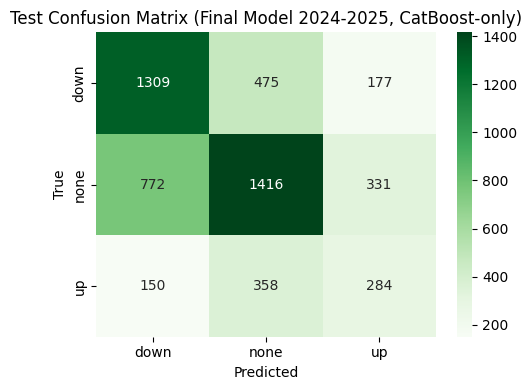

In [39]:
# Detailed diagnostics: classification reports and confusion matrices for folds and test set (CatBoost-only run)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels_sorted = sorted(trainval_df[label_col].astype(str).unique().tolist())
print("Class order:", labels_sorted)

# Per-fold reports using already-fitted predictors on disk
fold_reports = []
for row in cv_results.itertuples(index=False):
    fold_k = int(row.fold)
    print(f"\n=== Fold {fold_k} diagnostics (CatBoost-only) ===")
    fold_dir = MODELS_ROOT / "manual_timecv_2024_2025_cat_only" / f"fold{fold_k}"
    predictor_fold = TabularPredictor.load(str(fold_dir))
    _, val_fold = folds[fold_k]
    y_true_val = val_fold[label_col].astype(str)
    y_pred_val = predictor_fold.predict(val_fold)

    print("Classification report (validation):")
    print(classification_report(y_true_val, y_pred_val, labels=labels_sorted, zero_division=0))

    cm = confusion_matrix(y_true_val, y_pred_val, labels=labels_sorted)
    cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)
    fold_reports.append({"fold": fold_k, "report": cm_df})

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold_k} Confusion Matrix (Val, CatBoost-only)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Test-set diagnostics for final model
print("\n=== Test set diagnostics (final model, 2024-2025 CatBoost-only run) ===")
from autogluon.tabular import TabularPredictor as _TP
final_loaded = _TP.load(str(MODELS_ROOT / "manual_timecv_2024_2025_cat_only" / "final_full_trainval"))
y_true_test = test_df[label_col].astype(str)
y_pred_test = final_loaded.predict(test_df)

print("Classification report (test):")
print(classification_report(y_true_test, y_pred_test, labels=labels_sorted, zero_division=0))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=labels_sorted)
cm_test_df = pd.DataFrame(cm_test, index=labels_sorted, columns=labels_sorted)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_test_df, annot=True, fmt="d", cmap="Greens")
plt.title("Test Confusion Matrix (Final Model 2024-2025, CatBoost-only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()